1.构建回归数据集，被拟合的函数定义为：

In [44]:
def linear_func(x,w=1.2,b=0.5):
    y=w*x+b
    return y

2.为了模拟真实环境中样本通常包含噪声的问题，我们采样过程中加入高斯噪声和异常点。

In [45]:
import torch

def create_toy_data(func, interval, sample_num, noise=0.0, add_outlier=False, outlier_ratio=0.001):
    """
    根据给定的函数，生成样本
    输入：
       - func：函数
       - interval： x的取值范围
       - sample_num： 样本数目
       - noise： 噪声均方差
       - add_outlier：是否生成异常值
       - outlier_ratio：异常值占比
    输出：
       - X: 特征数据，shape=[n_samples,1]
       - y: 标签数据，shape=[n_samples,1]
    """

    # 均匀采样
    # 使用torch.rand生成sample_num个随机数
    X = torch.rand(sample_num) * (interval[1] - interval[0]) + interval[0]
    y = func(X)
    print(X)
    print(y)
    print(y.shape)

    # 生成高斯分布的标签噪声
    # 使用torch.normal生成0均值，noise标准差的数据
    epsilon = torch.normal(mean=torch.zeros(y.shape[0]), std=noise)
    y = y + epsilon
    if add_outlier:     # 生成额外的异常点
        outlier_num = int(len(y) * outlier_ratio)
        if outlier_num != 0:
            # 使用torch.randperm生成一个从0到len(y)-1的随机排列，然后选择前outlier_num个作为outlier_idx
            outlier_idx = torch.randperm(len(y))[:outlier_num]
            y[outlier_idx] = y[outlier_idx] * 5
    return X.unsqueeze(1), y.unsqueeze(1)

3.利用以上功能，生成线性函数的训练集和测试集，并绘制图像。

tensor([-0.9578, -8.8497, -8.6261, -8.9986, -9.7849, -9.3135, -7.5756, -9.0194,
        -9.3807,  4.3837,  6.1335,  6.7572,  5.3872,  3.3885,  4.4055, -5.5302,
         9.0035, -0.6896,  8.6280,  3.0657,  7.8272,  7.9770, -2.0894, -2.9085,
         1.5047, -0.4250,  1.5641,  5.0730, -7.8141, -0.4589, -7.8483,  9.6574,
        -7.0330,  1.9126, -2.7322,  5.6839,  0.0336, -1.0057,  7.3194,  9.1338,
        -7.2572, -9.6453,  0.8334,  3.1499,  2.2823,  9.2371,  4.4888, -4.6004,
        -6.8481,  7.7582,  9.5843, -4.7453, -6.4001,  3.5002, -7.1516, -2.4199,
        -9.8908,  2.7358, -3.4098, -5.5948, -6.3589, -3.5187,  4.7494,  0.5662,
         8.6114, -3.5742, -2.9265,  9.7876, -9.5385, -3.9364, -6.2038,  9.6213,
         5.3239, -3.3506, -4.2453,  3.0668, -3.3804,  3.1048, -5.1186, -6.1882,
        -0.2502,  5.8717,  8.5171,  2.2102, -5.9391,  5.2278,  3.8983,  4.2659,
        -3.3340, -1.3492,  4.6148,  4.1309,  6.6424, -5.9983,  6.2793, -3.8897,
        -0.2510, -4.7068, -2.9644,  6.74

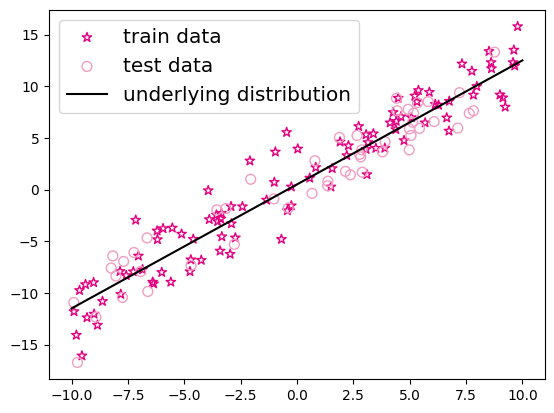

In [46]:
from matplotlib import pyplot as plt

func = linear_func
interval = (-10,10)
train_num = 100
test_num = 50
noise = 2
X_train,y_train = create_toy_data(func=func,interval=interval,sample_num=train_num,noise=noise,add_outlier=False)
X_test,y_test = create_toy_data(func=func,interval=interval,sample_num=test_num,noise=noise,add_outlier=False)

X_train_large,y_train_large = create_toy_data(func=func,interval=interval,sample_num=5000,noise=noise,add_outlier=True)

X_underlying = torch.linspace(interval[0],interval[1],train_num)
y_underlying = linear_func(X_underlying)

plt.scatter(X_train, y_train, marker='*', facecolor="none", edgecolor='#e4007f', s=50, label="train data")
plt.scatter(X_test, y_test, facecolor="none", edgecolor='#f19ec2', s=50, label="test data")
plt.plot(X_underlying, y_underlying, c='#000000', label=r"underlying distribution")
plt.legend(fontsize='x-large') # 给图像加图例
plt.savefig('ml-vis.pdf') # 保存图像到PDF文件中
plt.show()

4.构建线性回归模型

In [51]:
import torch
from torch.nn import Module

torch.manual_seed(10)  # 设置随机种子

# 线性算子
class Linear(Module):
    def __init__(self, input_size):
        self.params = {'w': None, 'b': None}
        """
        输入：
           - input_size: 模型要处理的数据特征向量长度
        """
        super(Linear, self).__init__()
        self.input_size = input_size

        # 模型参数
        self.w = torch.randn(input_size, 1, dtype=torch.float32, requires_grad=True)
        self.b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

    def forward(self, X):
        """
        输入：
           - X: tensor, shape=[N, D]
           注意这里的X矩阵是由N个x向量的转置拼接成的，与原教材行向量表示方式不一致
        输出：
           - y_pred： tensor, shape=[N]
        """
        N, D = X.shape

        if self.input_size == 0:
            return torch.full((N, 1), fill_value=self.b.item())

        assert D == self.input_size, "输入数据维度不匹配"

        # 使用torch.matmul计算两个tensor的乘积
        y_pred = torch.matmul(X, self.w) + self.b

        return y_pred.squeeze()

# 设置输入大小和样本数量
input_size = 3
N = 2

# 生成2个维度为3的数据
X = torch.randn(N, input_size, dtype=torch.float32)

# 创建模型
model = Linear(input_size)

# 前向传播
y_pred = model(X)

print("y_pred:", y_pred)  # 输出结果的个数也是2个

y_pred: tensor([1.8529, 0.6011], grad_fn=<SqueezeBackward0>)


5.定义损失函数

In [52]:
import torch

def mean_squared_error(y_true, y_pred):
    """
    输入：
       - y_true: tensor，样本真实标签
       - y_pred: tensor, 样本预测标签
    输出：
       - error: float，误差值
    """

    assert y_true.shape == y_pred.shape, "形状不匹配"

    # torch.square 计算输入的平方值
    # torch.mean 沿 axis 计算 x 的平均值，默认axis是None，则对输入的全部元素计算平均值。
    error = torch.mean(torch.square(y_true - y_pred))

    return error.item()


# 构造一个简单的样例进行测试:[N,1], N=2
y_true = torch.tensor([[-0.2], [4.9]], dtype=torch.float32)
y_pred = torch.tensor([[1.3], [2.5]], dtype=torch.float32)

error = mean_squared_error(y_true=y_true, y_pred=y_pred)
print("error:", error)

error: 4.005000114440918


6.优化模型参数

In [69]:
import torch

class LinearModel:
    def __init__(self):
        self.params = {'w': None, 'b': None}

def optimizer_lsm(model, X, y, reg_lambda=0):
    """
    输入：
       - model: 模型
       - X: tensor, 特征数据，shape=[N,D]
       - y: tensor, 标签数据，shape=[N]
       - reg_lambda: float, 正则化系数，默认为0
    输出：
       - model: 优化好的模型
    """

    N, D = X.shape

    # 对输入特征数据所有特征向量求平均
    x_bar = torch.mean(X, dim=0)
    
    # 求标签的均值, shape=[1]
    y_bar = torch.mean(y)
    
    # 通过广播的方式实现矩阵减向量
    x_sub = X - x_bar.view(1, -1)
    
    # 检查 x_sub 是否全为0
    if torch.all(x_sub == 0):
        model.params['b'] = y_bar
        model.params['w'] = torch.zeros(D)
        return model
    
    # 求方阵的逆
    tmp = torch.inverse(torch.matmul(x_sub.T, x_sub) + 
                        reg_lambda * torch.eye(D))
    
    # 计算 w
    w = torch.matmul(torch.matmul(tmp, x_sub.T), (y - y_bar))
    
    # 计算 b
    b = y_bar - torch.matmul(x_bar, w)
    
    model.params['b'] = b
    model.params['w'] = w.squeeze()

    return model

7.模型预测

In [70]:
input_size = 1
model = Linear(input_size)
model = optimizer_lsm(model,X_train, y_train, reg_lambda=0.1)

print("w_pred:", model.params['w'].item(), "b_pred:", model.params['b'].item())
y_train_pred = torch.matmul(X_train, model.params['w'].unsqueeze(-1)).squeeze() + model.params['b']
train_error = mean_squared_error(y_train, y_train_pred.t())
print("train error:", train_error)

w_pred: 1.2366359233856201 b_pred: 0.7418786287307739


AssertionError: 形状不匹配